In [5]:
# conda activate aso_design
import pandas as pd
from scripts.data_genertion.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict
from asodesigner.consts import *
import numpy as np
from asodesigner.util import get_antisense
import pickle
from read_human_genome import get_locus_to_data_dict
from file_utils import read_human_genome_fasta_dict
import RNA

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
csv_path = os.path.join(project_root, 'scripts', 'data_genertion', 'data_asoptimizer_updated.csv')
all_data = pd.read_csv(csv_path)

/tmp/ipykernel_11149/3793884771.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(csv_path)


In [4]:
# Column name definitions from the ASO experiment dataset.
SEQUENCE = 'Sequence'
INHIBITION = 'Inhibition(%)'
CANONICAL_GENE = 'Canonical Gene Name'
CELL_LINE_ORGANISM = 'Cell line organism'
VOLUME = 'ASO_volume(nM)'
TREATMENT_PERIOD = 'Treatment_Period(hours)'
CELL_LINE = 'Cell_line'
TRANSFECTION = 'Transfection'
DENSITY = 'Density(cells/well)'
MODIFICATION = 'Modification'

Preprocessing ASO Experimental Dataset

In [5]:
# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001) #to avoid log 0

In [6]:
# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
# Remove non-human or negative controls from the gene list
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [7]:
# Load gene information from cache or generate it if needed
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)


In [8]:
# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

# Define names for new columns
SENSE_SEQUENCE = 'sense_sequence'
PRE_MRNA_SEQUENCE = 'pre_mrna_sequence'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'

# Initialize new columns
all_data_human_gene[SENSE_SEQUENCE] = ""
all_data_human_gene[PRE_MRNA_SEQUENCE] = ""
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)

# Iterate over each row and compute the antisense complement and the gene's pre-mRNA
for index, row in all_data_human_gene.iterrows():
    gene_name = row[CANONICAL_GENE]

    if gene_name not in gene_to_data:
        continue  # Skip genes not found in genome annotation

    locus_info = gene_to_data[gene_name]
    pre_mrna = locus_info.full_mrna
    antisense = row[SEQUENCE]
    sense = get_antisense(antisense)
    idx = pre_mrna.find(sense)

    # Store computed sequences in new columns
    all_data_human_gene.loc[index, SENSE_START] = idx
    all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)
    all_data_human_gene.at[index, SENSE_SEQUENCE] = sense
    all_data_human_gene.at[index, PRE_MRNA_SEQUENCE] = pre_mrna

In [9]:
all_data_human_gene.head()

,index,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,...,Location_in_sequence,Location_div_by_length,true_length_of_seq,mod_scan,cell_line_uniform,log_inhibition,sense_sequence,pre_mrna_sequence,sense_start,sense_length
0,0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,...,41212.0,0.901972,16,0,A431,-4.204708,TAGCATTTGTTTTAGC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",41212,16
1,1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,...,23686.0,0.518395,16,0,A431,-4.532610,GATATTCACCATTATA,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",23686,16
2,2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,...,43363.0,0.949049,16,1,A431,-3.637612,CCAGAAATCTTCATGC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",43363,16
3,3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,...,23680.0,0.518264,16,0,A431,-4.276680,TTTGAAGATATTCACC,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",23680,16
4,4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,...,41168.0,0.901009,16,0,A431,-4.158899,CATACTAGTACAAGTG,"(G, A, T, T, T, T, C, C, T, A, G, G, C, G, G, ...",41168,16


In [10]:
def get_sense_with_flanks(pre_mrna: str, sense_start: int, sense_length: int, flank_size: int) -> str:
    """
    Re  turns the sense sequence with `flank_size` nucleotides on each side (if available).
    If near the edge, it will not go out of bounds.

    Parameters:
    - pre_mrna: The full pre-mRNA sequence (5' -> 3')
    - sense_start: Start index of the sense sequence within pre_mrna
    - sense_length: Length of the sense sequence (usually same as antisense length)
    - flank_size: Number of nucleotides to include on each side (upstream and downstream)

    Returns:
    - str: The flanked sense sequence
    """
    # Ensure indices are within bounds
    start = max(0, sense_start - flank_size)
    end = min(len(pre_mrna), sense_start + sense_length + flank_size)

    return pre_mrna[start:end]

In [11]:
FLANK_SIZE = 120  # Change this as needed
FLANKED_SENSE_COL = f'sense_with_flank_{FLANK_SIZE}nt'

# Create new column with flanked sequences
all_data_human_gene[FLANKED_SENSE_COL] = all_data_human_gene.apply(
    lambda row: get_sense_with_flanks(
        row['pre_mrna_sequence'],
        row['sense_start'],
        row['sense_length'],
        flank_size=FLANK_SIZE
    ) if row['sense_start'] != -1 else "",  # Handle cases where sense was not found
    axis=1
)

ViennaRNA energy calculation

In [12]:
from tqdm import tqdm
from scipy.stats import spearmanr
import ViennaRNA
from Bio.Seq import Seq

In [13]:
def calculate_avg_mfe_over_sense_region(sequence, sense_start, sense_length, flank_size=120, window_size=120, step=1):
    sequence = str(sequence).upper().replace('T', 'U')
    sequence_length = len(sequence)
    energy_values = np.zeros(sequence_length)
    counts = np.zeros(sequence_length)

    for i in range(0, sequence_length - window_size + 1, step):
        subseq = sequence[i:i + window_size]
        fc = ViennaRNA.fold_compound(subseq)
        _, mfe = fc.mfe()
        mfe_per_nt = mfe / window_size

        for j in range(i, i + window_size):
            energy_values[j] += mfe_per_nt
            counts[j] += 1

    counts[counts == 0] = 1
    avg_energies = energy_values / counts

    flank_start = max(0, sense_start - flank_size)
    sense_start_in_flank = sense_start - flank_start
    sense_end_in_flank = sense_start_in_flank + sense_length

    if 0 <= sense_start_in_flank < sequence_length and sense_end_in_flank <= sequence_length:
        return np.mean(avg_energies[sense_start_in_flank:sense_end_in_flank])
    else:
        return np.nan


### Final best parameters
Parameters that were tested:

- **Step sizes:**
  `[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`

- **Windows sizes:**
  `[20, 30, ,35, 40, 45, 50, 60, 70]`

The chosen parameters are: window size = 45, step = 7

In [14]:
from tqdm import tqdm
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

# Define flank size and relevant column name
FLANK_SIZE = 120
FLANKED_SENSE_COL = f'sense_with_flank_{FLANK_SIZE}nt'

# Copy the full DataFrame to avoid modifying the original
df_all = all_data_human_gene.copy()

# Filter for valid rows: valid sense start, non-null sequence, and sufficient length
valid_mask = (
    (df_all['sense_start'] != -1) &
    (df_all[FLANKED_SENSE_COL].notna()) &
    (df_all[FLANKED_SENSE_COL].str.len() >= FLANK_SIZE)
)
df_valid = df_all.loc[valid_mask].copy().reset_index()  # Add original index as a column

# Compute the average MFE over the sense region using sliding windows
tqdm.pandas(desc="Computing final MFE (window=45)")
df_valid['mfe_window_45'] = df_valid.progress_apply(
    lambda row: calculate_avg_mfe_over_sense_region(
        sequence=row[FLANKED_SENSE_COL],
        sense_start=row['sense_start'],
        sense_length=row['sense_length'],
        flank_size=FLANK_SIZE,
        window_size=45,
        step=7
    ),
    axis=1
)

# Filter rows with non-missing MFE and inhibition values
df_mfe_vs_inhibition = df_valid.dropna(subset=['mfe_window_45', 'log_inhibition'])[
    ['index', 'mfe_window_45', 'log_inhibition']
].copy()

# Compute Spearman correlation
corr, pval = spearmanr(df_mfe_vs_inhibition['mfe_window_45'], df_mfe_vs_inhibition['log_inhibition'])
print(f"Spearman correlation = {corr:.3f}, p-value = {pval:.3g}")

# Save to CSV
# Save only the index and mfe_window_45 columns
df_mfe_vs_inhibition[['index', 'mfe_window_45']].to_csv("avg_mfe_vienna_window45_flank120_step7.csv", index=False)

Computing final MFE (window=45): 100%|██████████| 29987/29987 [19:07<00:00, 26.12it/s]  


Spearman correlation = 0.143, p-value = 5.71e-136


In [17]:
df_mfe_vs_inhibition.head()

,index,mfe_window_45,log_inhibition
0,0,-0.075053,-4.204708
1,1,-0.128003,-4.532610
2,2,-0.098254,-3.637612
3,3,-0.115271,-4.276680
4,4,-0.133168,-4.158899


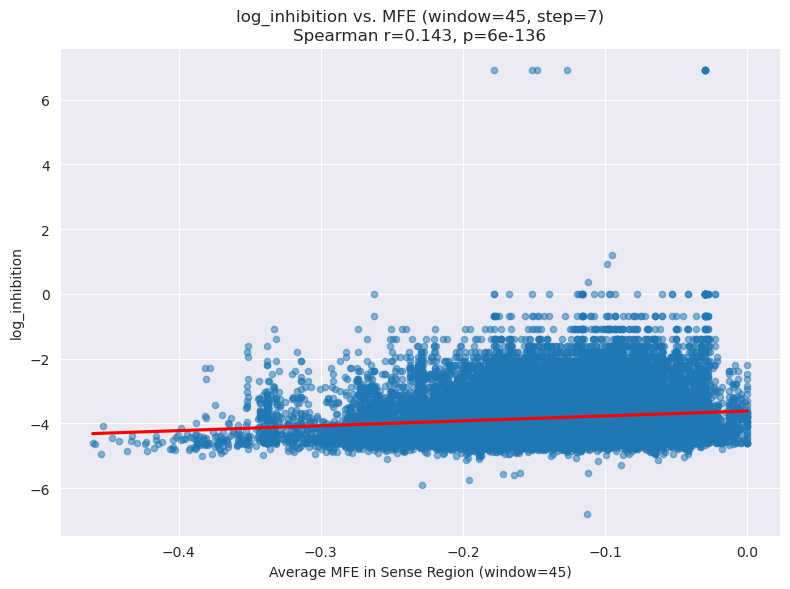

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Create scatter plot with regression line
sns.regplot(
    x='mfe_window_45',
    y='log_inhibition',
    data=df_mfe_vs_inhibition,
    scatter_kws={'s': 20, 'alpha': 0.5},  # Small, semi-transparent points
    line_kws={'color': 'red'},            # Red regression line
    ci=None                               # No confidence interval
)

# Set plot title and labels
plt.title(f'log_inhibition vs. MFE (window=45, step=7)\nSpearman r={corr:.3f}, p={pval:.1g}')
plt.xlabel('Average MFE in Sense Region (window=45)')
plt.ylabel('log_inhibition')
plt.grid(True)
plt.tight_layout()
plt.show()

### Calculate average mfe over the edges of the mRNA sense

In [16]:
def calculate_mfe_over_edges_sense_region(sequence, sense_start, sense_length, flank_size=45, window_size=45, step=7):
    sequence = str(sequence).upper().replace('T', 'U')
    sequence_length = len(sequence)
    energy_values = np.zeros(sequence_length)
    counts = np.zeros(sequence_length)

    for i in range(0, sequence_length - window_size + 1, step):
        subseq = sequence[i:i + window_size]
        fc = ViennaRNA.fold_compound(subseq)
        _, mfe = fc.mfe()
        mfe_per_nt = mfe / window_size

        for j in range(i, i + window_size):
            energy_values[j] += mfe_per_nt
            counts[j] += 1

    counts[counts == 0] = 1
    avg_energies = energy_values / counts

    flank_start = max(0, sense_start - flank_size)
    sense_start_in_flank = sense_start - flank_start
    sense_end_in_flank = sense_start_in_flank + sense_length

    if 0 <= sense_start_in_flank < sequence_length and sense_end_in_flank <= sequence_length:
        return np.mean(np.concatenate([(avg_energies[sense_start_in_flank:sense_start_in_flank+4]), (avg_energies[sense_end_in_flank-4:sense_end_in_flank])]))
    else:
        return np.nan


In [18]:
from tqdm import tqdm
import numpy as np

# Set flank size and define the column name for the flanked RNA sequence
FLANK_SIZE = 120
FLANKED_SENSE_COL = f'sense_with_flank_{FLANK_SIZE}nt'

# Create a copy of the original DataFrame
df_all = all_data_human_gene.copy()

# Filter valid rows: must have a valid sense_start, non-null sequence, and sufficient length
valid_mask = (
    (df_all['sense_start'] != -1) &
    (df_all[FLANKED_SENSE_COL].notna()) &
    (df_all[FLANKED_SENSE_COL].str.len() >= FLANK_SIZE)
)
df_valid = df_all.loc[valid_mask].copy().reset_index()  # Preserve original index as a column

# Compute average MFE over the edges (first and last 4 nt) of the sense region
tqdm.pandas(desc="Computing edge-only MFE (window=45)")
df_valid['mfe_edges_45'] = df_valid.progress_apply(
    lambda row: calculate_mfe_over_edges_sense_region(
        sequence=row[FLANKED_SENSE_COL],
        sense_start=row['sense_start'],
        sense_length=row['sense_length'],
        flank_size=FLANK_SIZE,
        window_size=45,
        step=7
    ),
    axis=1
)

# Keep only relevant columns and save to CSV
df_mfe_edges = df_valid[['index', 'mfe_edges_45']].copy()
df_mfe_edges.to_csv("mfe_edges_vienna_window45_flank120_step7.csv", index=False)

Computing edge-only MFE (window=45): 100%|██████████| 29987/29987 [16:12<00:00, 30.82it/s] 


In [21]:
df_mfe_edges_corr = df_valid[['index', 'mfe_edges_45','log_inhibition']].copy()
df_mfe_edges_corr.head()

,index,mfe_edges_45,log_inhibition
0,0,-0.076025,-4.204708
1,1,-0.126501,-4.532610
2,2,-0.095073,-3.637612
3,3,-0.114187,-4.276680
4,4,-0.131343,-4.158899


In [22]:
# Compute Spearman correlation
corr, pval = spearmanr(df_mfe_edges_corr['mfe_edges_45'], df_mfe_edges_corr['log_inhibition'])
print(f"Spearman correlation = {corr:.3f}, p-value = {pval:.3g}")

Spearman correlation = 0.142, p-value = 1.18e-135


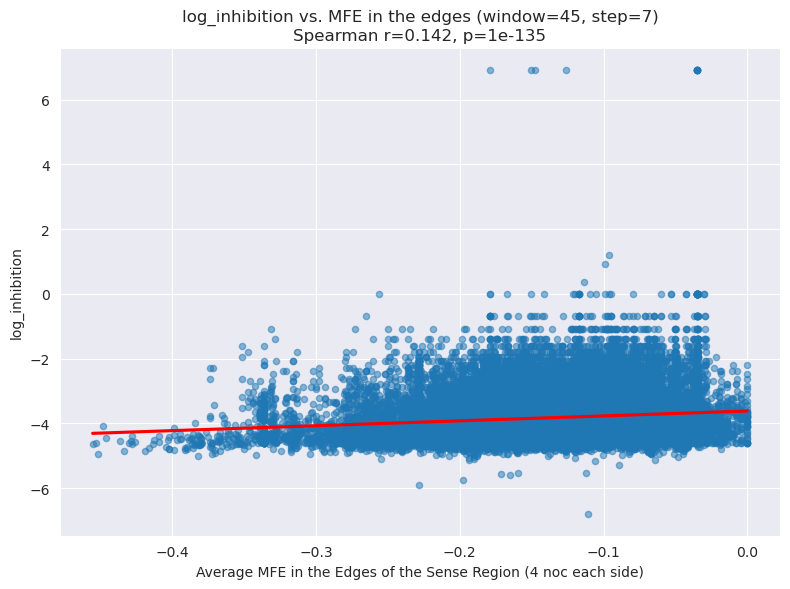

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Create scatter plot with regression line
sns.regplot(
    x='mfe_edges_45',
    y='log_inhibition',
    data=df_mfe_edges_corr,
    scatter_kws={'s': 20, 'alpha': 0.5},  # Small, semi-transparent points
    line_kws={'color': 'red'},            # Red regression line
    ci=None                               # No confidence interval
)

# Set plot title and labels
plt.title(f'log_inhibition vs. MFE in the edges (window=45, step=7)\nSpearman r={corr:.3f}, p={pval:.1g}')
plt.xlabel('Average MFE in the Edges of the Sense Region (4 noc each side)')
plt.ylabel('log_inhibition')
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts', 'features')))

from feature_extraction import save_feature

In [6]:
df_avg_mfe_wind45_flank120_step7 = pd.read_csv("avg_mfe_vienna_window45_flank120_step7.csv")

In [7]:
df_avg_mfe_wind45_flank120_step7.head()

,index,mfe_window_45
0,0,-0.075053
1,1,-0.128003
2,2,-0.098254
3,3,-0.115271
4,4,-0.133168


In [9]:
save_feature(df_avg_mfe_wind45_flank120_step7, 'mfe_window_45')

In [10]:
mfe_edges_wind45_flank120_step7 = pd.read_csv("mfe_edges_vienna_window45_flank120_step7.csv")

In [11]:
mfe_edges_wind45_flank120_step7.head()

,index,mfe_edges_45
0,0,-0.076025
1,1,-0.126501
2,2,-0.095073
3,3,-0.114187
4,4,-0.131343


In [12]:
save_feature(mfe_edges_wind45_flank120_step7, 'mfe_edges_45')